# アパレル店の売上データの解析
　中間レポート課題のapparel.xlsxは，アパレル店の売上データであり，バーゲンを実施したか否か，天候が雨だったか否かの情報を記録したデータである．このデータを状態空間モデルを用いて解析して，レストランの売り上げデータと同様に，アパレル店の売上データについても解析してみよう．



In [9]:
import prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
df = pd.read_excel('../data/apparel.xlsx')
df.head(3)

,ds,Weather,Bargain,y
0,1990-01-05,0.0,0.0,58507.0
1,1990-01-06,0.0,0.0,49088.0
2,1990-01-07,0.0,0.0,50066.0


In [7]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
ds,1457,1992-01-03 00:00:00,1990-01-05 00:00:00,1991-01-04 00:00:00,1992-01-03 00:00:00,1993-01-01 00:00:00,1993-12-31 00:00:00,NaN
Weather,1290.0,0.26124,0.0,0.0,0.0,1.0,1.0,0.439481
Bargain,1290.0,0.269767,0.0,0.0,0.0,1.0,1.0,0.444011
y,1290.0,90401.186047,23122.0,67302.25,82822.0,102247.75,386720.0,39312.323862


データは日付のほかに，Weatherが1だった場合は雨，Bargainが1だった場合はバーゲンを実施，yはその日の売り上げといった形となっている．休業日の場合はデータは欠損となっている．まずはデータをプロットしてみよう．

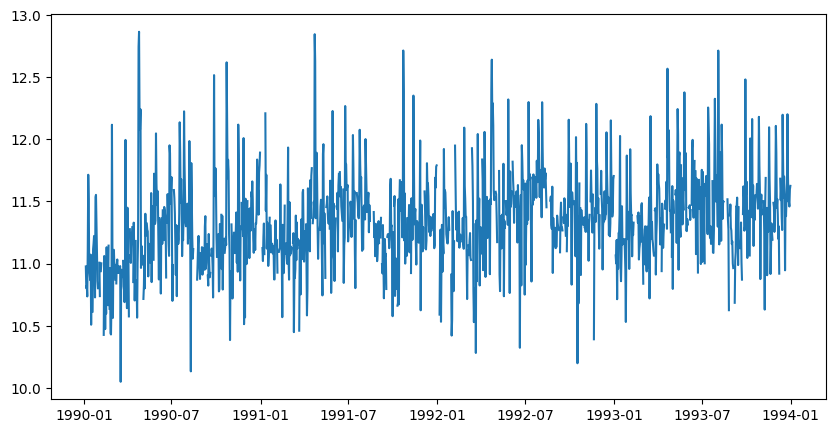

In [10]:
df['ds'] = pd.to_datetime(df['ds'])

#y列を対数変換
df['y'] = np.log(df['y'])

#時系列プロット
#画像サイズを設定
plt.figure(figsize=(10,5),dpi=100)
plt.plot(df['ds'], df['y'])

## 課題内容
上記のデータについて周期性やイベント効果（バーゲン，天候）を入れて予測モデルを構築してみよう．また，余裕があったら祝日効果も考慮に入れて予測モデルを組んでみよう．日本の祝日については以下のコマンドで取得可能である．

In [11]:
#jpholidayライブラリのインストール
!pip install jpholiday

jpholidayライブラリは以下のように使用する．

In [15]:
# 指定年の祝日を取得
import jpholiday
jpholiday.year_holidays(2017)
# >[(datetime.date(2017, 1, 1), '元日'),
#  (datetime.date(2017, 1, 2), '元日 振替休日'),
#  (datetime.date(2017, 1, 9), '成人の日'),
#  (datetime.date(2017, 2, 11), '建国記念の日'),
#  (datetime.date(2017, 3, 20), '春分の日'),
#  (datetime.date(2017, 4, 29), '昭和の日'),
#  (datetime.date(2017, 5, 3), '憲法記念日'),
#  (datetime.date(2017, 5, 4), 'みどりの日'),
#  (datetime.date(2017, 5, 5), 'こどもの日'),
#  (datetime.date(2017, 7, 17), '海の日'),
#  (datetime.date(2017, 8, 11), '山の日'),
#  (datetime.date(2017, 9, 18), '敬老の日'),
#  (datetime.date(2017, 9, 23), '秋分の日'),
#  (datetime.date(2017, 10, 9), '体育の日'),
#  (datetime.date(2017, 11, 3), '文化の日'),
#  (datetime.date(2017, 11, 23), '勤労感謝の日'),
#  (datetime.date(2017, 12, 23), '天皇誕生日')]

[(datetime.date(2017, 1, 1), '元日'),
 (datetime.date(2017, 1, 2), '元日 振替休日'),
 (datetime.date(2017, 1, 9), '成人の日'),
 (datetime.date(2017, 2, 11), '建国記念の日'),
 (datetime.date(2017, 3, 20), '春分の日'),
 (datetime.date(2017, 4, 29), '昭和の日'),
 (datetime.date(2017, 5, 3), '憲法記念日'),
 (datetime.date(2017, 5, 4), 'みどりの日'),
 (datetime.date(2017, 5, 5), 'こどもの日'),
 (datetime.date(2017, 7, 17), '海の日'),
 (datetime.date(2017, 8, 11), '山の日'),
 (datetime.date(2017, 9, 18), '敬老の日'),
 (datetime.date(2017, 9, 23), '秋分の日'),
 (datetime.date(2017, 10, 9), '体育の日'),
 (datetime.date(2017, 11, 3), '文化の日'),
 (datetime.date(2017, 11, 23), '勤労感謝の日'),
 (datetime.date(2017, 12, 23), '天皇誕生日')]

In [16]:
# 指定月の祝日を取得
import jpholiday
jpholiday.month_holidays(2017, 5)
# >[(datetime.date(2017, 5, 3), '憲法記念日'),
#  (datetime.date(2017, 5, 4), 'みどりの日'),
#  (datetime.date(2017, 5, 5), 'こどもの日')]

[(datetime.date(2017, 5, 3), '憲法記念日'),
 (datetime.date(2017, 5, 4), 'みどりの日'),
 (datetime.date(2017, 5, 5), 'こどもの日')]

In [20]:
# 指定範囲の祝日を取得
import jpholiday
import datetime

# jpholiday.holidays は存在しないため、指定範囲の日付を走査して祝日を検索する
start = datetime.date(2017, 1, 1)
end = datetime.date(2017, 5, 3)
delta = end - start

holidays_in_range = []
for i in range(delta.days + 1):
    day = start + datetime.timedelta(days=i)
    holiday_name = jpholiday.is_holiday_name(day)
    if holiday_name is not None:
        holidays_in_range.append((day, holiday_name))

print(holidays_in_range)
# >[(datetime.date(2017, 1, 1), '元日'),
#  (datetime.date(2017, 1, 2), '元日 振替休日'),
#  (datetime.date(2017, 1, 9), '成人の日'),
#  (datetime.date(2017, 2, 11), '建国記念の日'),
#  (datetime.date(2017, 3, 20), '春分の日'),
#  (datetime.date(2017, 4, 29), '昭和の日'),
#  (datetime.date(2017, 5, 3), '憲法記念日')]

[(datetime.date(2017, 1, 1), '元日'), (datetime.date(2017, 1, 2), '元日 振替休日'), (datetime.date(2017, 1, 9), '成人の日'), (datetime.date(2017, 2, 11), '建国記念の日'), (datetime.date(2017, 3, 20), '春分の日'), (datetime.date(2017, 4, 29), '昭和の日'), (datetime.date(2017, 5, 3), '憲法記念日')]


今回は，1990年から1993年までのデータであるので，その祝日の情報が必要になる．このとき，祝日の名前は必要ないので，

In [22]:
# 1990年～1993年の祝日を取得する
import jpholiday
import datetime

start_date = datetime.date(1990, 1, 1)
end_date = datetime.date(1993, 12, 31)
delta = end_date - start_date

hd = []
for i in range(delta.days + 1):
    day = start_date + datetime.timedelta(days=i)
    if jpholiday.is_holiday(day):
        hd.append(day)
print(hd)

[datetime.date(1990, 1, 1), datetime.date(1990, 1, 15), datetime.date(1990, 2, 11), datetime.date(1990, 2, 12), datetime.date(1990, 3, 21), datetime.date(1990, 4, 29), datetime.date(1990, 4, 30), datetime.date(1990, 5, 3), datetime.date(1990, 5, 4), datetime.date(1990, 5, 5), datetime.date(1990, 9, 15), datetime.date(1990, 9, 23), datetime.date(1990, 9, 24), datetime.date(1990, 10, 10), datetime.date(1990, 11, 3), datetime.date(1990, 11, 12), datetime.date(1990, 11, 23), datetime.date(1990, 12, 23), datetime.date(1990, 12, 24), datetime.date(1991, 1, 1), datetime.date(1991, 1, 15), datetime.date(1991, 2, 11), datetime.date(1991, 3, 21), datetime.date(1991, 4, 29), datetime.date(1991, 5, 3), datetime.date(1991, 5, 4), datetime.date(1991, 5, 5), datetime.date(1991, 5, 6), datetime.date(1991, 9, 15), datetime.date(1991, 9, 16), datetime.date(1991, 9, 23), datetime.date(1991, 10, 10), datetime.date(1991, 11, 3), datetime.date(1991, 11, 4), datetime.date(1991, 11, 23), datetime.date(1991, 1

のようにして，日付のみ取得する．